<a href="https://colab.research.google.com/github/jc890/python/blob/master/casestudy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

# Wholesale_Customers_Clustering

# Heading: Imports and helper functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

# Make plots large enough
plt.rcParams['figure.figsize'] = (10,6)

# Utility: show dataframe info

def brief(df):
    print('\nDataframe shape:', df.shape)
    display(df.head())
    print('\nMissing values per column:')
    print(df.isnull().sum())



In [27]:

# Heading: 1. Read the dataset to the python environment
# Place the CSV file in the same directory, or provide path. Filename below is the common one from UCI/assignment.
DATA_PATH = '/content/Wholesale customers data.csv' # change if your filename differs


if not os.path.exists(DATA_PATH):
 print(f"File not found at '{DATA_PATH}'. Please upload the dataset to the working directory or change DATA_PATH.")
else:
 df = pd.read_csv(DATA_PATH)
 print('Loaded dataset from', DATA_PATH)
 brief(df)

Loaded dataset from /content/Wholesale customers data.csv

Dataframe shape: (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185



Missing values per column:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [28]:
# Heading: 2. Preprocessing
# Typical Wholesale customers dataset has columns: Channel, Region, Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen
# We'll drop non-feature columns for clustering (Channel/Region) but keep a copy for interpretation.


try:
  feature_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
  features = df[feature_cols].copy()
except Exception:
# If dataset has slight different column names, take numeric cols except ID
  features = df.select_dtypes(include=[np.number]).copy()
if 'Channel' in features.columns:
  features = features.drop(columns=['Channel'])


print('Features used for clustering:')
print(list(features.columns))


# Log transform (optional) to reduce skewness
features_log = np.log1p(features)


# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(features_log)

Features used for clustering:
['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


Explained variance (2 components): 0.7127266893428759


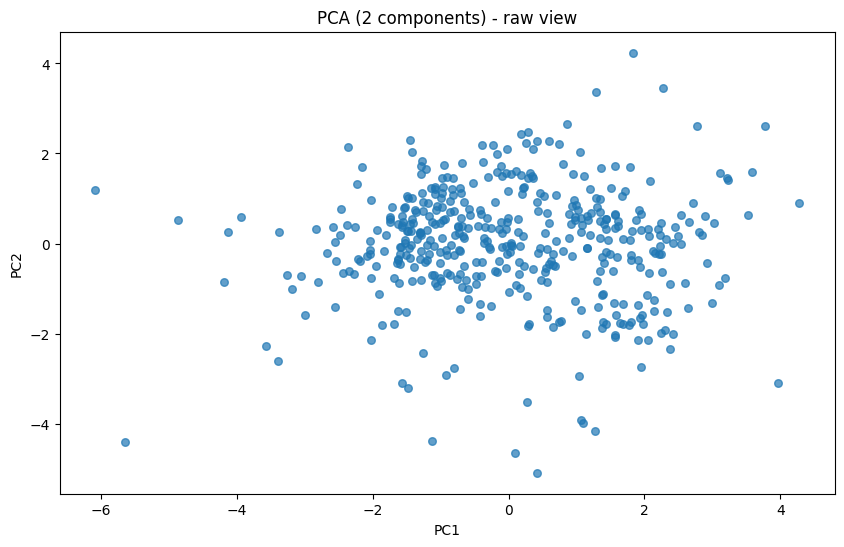

In [29]:
# Heading: 3. PCA for quick visualization (before clustering)
pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(X)
print('Explained variance (2 components):', pca.explained_variance_ratio_.sum())


plt.figure()
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=30, alpha=0.7)
plt.title('PCA (2 components) - raw view')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.grid(False)

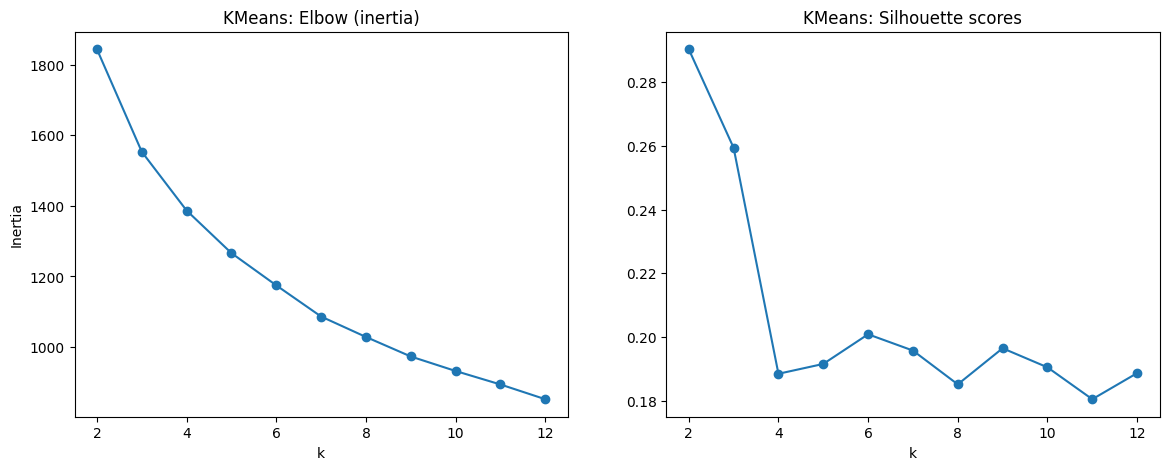

Calinski-Harabasz scores:
k=2: CH=189.05
k=3: CH=152.84
k=4: CH=131.32
k=5: CH=118.00
k=6: CH=108.26
k=7: CH=103.21
k=8: CH=96.70
k=9: CH=92.28
k=10: CH=87.56
k=11: CH=83.81
k=12: CH=81.65

KMeans silhouette-optimal k = 2


Text(0.5, 1.0, 'KMeans (k=2) on PCA(2)')

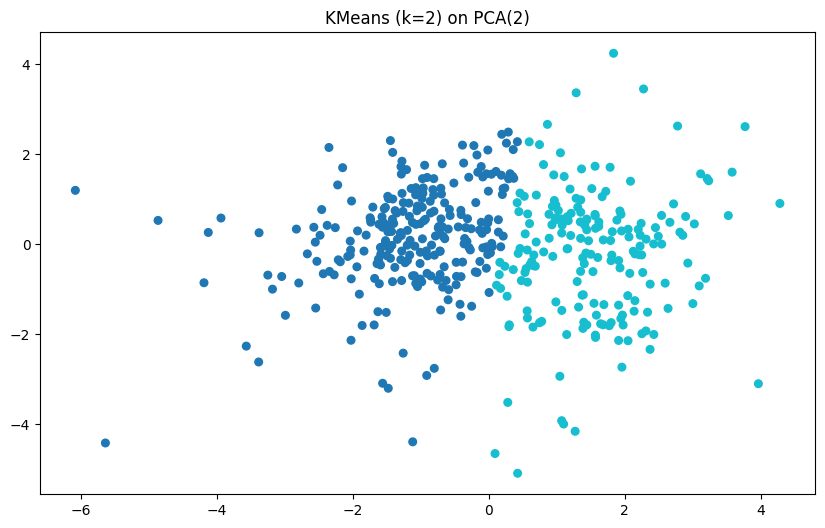

In [30]:
# Heading: 4. KMeans: elbow and silhouette to find optimal K
max_k = 12
inertia = []
sil_scores = []
ch_scores = []
K_range = range(2, max_k+1)
for k in K_range:
  km = KMeans(n_clusters=k, random_state=42, n_init=10)
  labels = km.fit_predict(X)
  inertia.append(km.inertia_)
  sil_scores.append(silhouette_score(X, labels))
  ch_scores.append(calinski_harabasz_score(X, labels))


# Plot elbow and silhouette
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(list(K_range), inertia, '-o')
ax[0].set_title('KMeans: Elbow (inertia)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')


ax[1].plot(list(K_range), sil_scores, '-o')
ax[1].set_title('KMeans: Silhouette scores')
ax[1].set_xlabel('k')


plt.show()


print('Calinski-Harabasz scores:')
for k, val in zip(K_range, ch_scores):
  print(f'k={k}: CH={val:.2f}')


# Choose optimal k where silhouette and CH peak or elbow point — here we will pick k_opt automatically as silhouette argmax
k_opt = K_range[int(np.argmax(sil_scores))]
print('\nKMeans silhouette-optimal k =', k_opt)


# Fit final KMeans
kmeans_final = KMeans(n_clusters=k_opt, random_state=42, n_init=20)
kmeans_labels = kmeans_final.fit_predict(X)


# Visualize on PCA
plt.figure()
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=kmeans_labels, cmap='tab10', s=30)
plt.title(f'KMeans (k={k_opt}) on PCA(2)')

Agglomerative silhouette-optimal k = 2


Text(0.5, 1.0, 'Agglomerative (k=2) on PCA(2)')

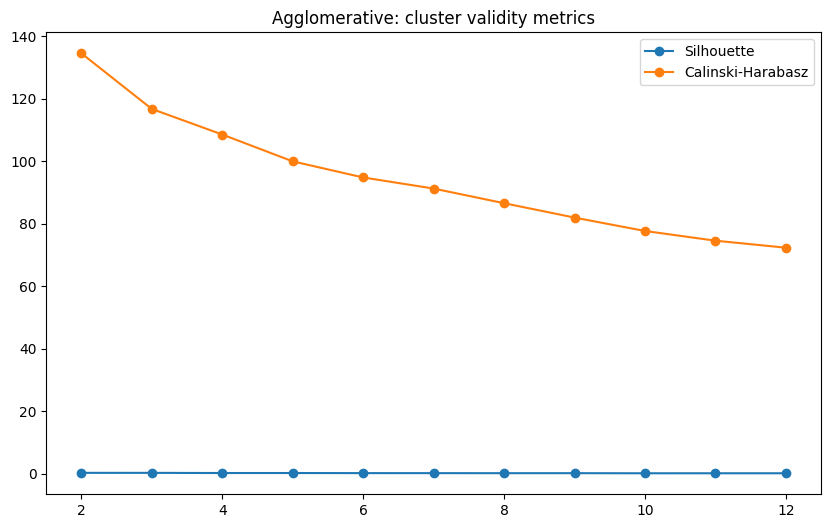

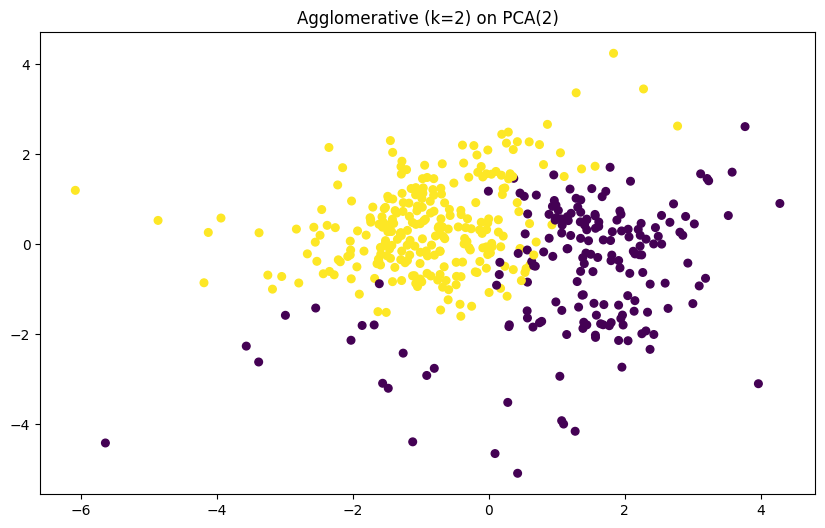

In [31]:
# Heading: 5. Agglomerative Clustering (Hierarchical) - silhouette & CH
from sklearn.cluster import AgglomerativeClustering


agg_sil = []
agg_ch = []
for k in K_range:
  agg= AgglomerativeClustering(n_clusters=k)
  labels = agg.fit_predict(X)
  agg_sil.append(silhouette_score(X, labels))
  agg_ch.append(calinski_harabasz_score(X, labels))


plt.figure()
plt.plot(list(K_range), agg_sil, '-o', label='Silhouette')
plt.plot(list(K_range), agg_ch, '-o', label='Calinski-Harabasz')
plt.legend()
plt.title('Agglomerative: cluster validity metrics')


k_opt_agg = K_range[int(np.argmax(agg_sil))]
print('Agglomerative silhouette-optimal k =', k_opt_agg)


agg_final = AgglomerativeClustering(n_clusters=k_opt_agg)
agg_labels = agg_final.fit_predict(X)


plt.figure()
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=agg_labels, s=30)
plt.title(f'Agglomerative (k={k_opt_agg}) on PCA(2)')

GMM BIC-optimal components = 4


Text(0.5, 1.0, 'GMM (components=4) on PCA(2)')

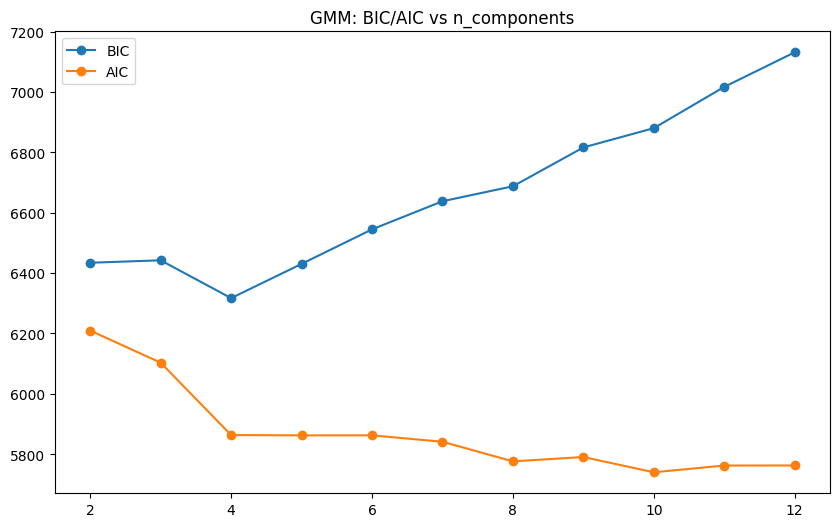

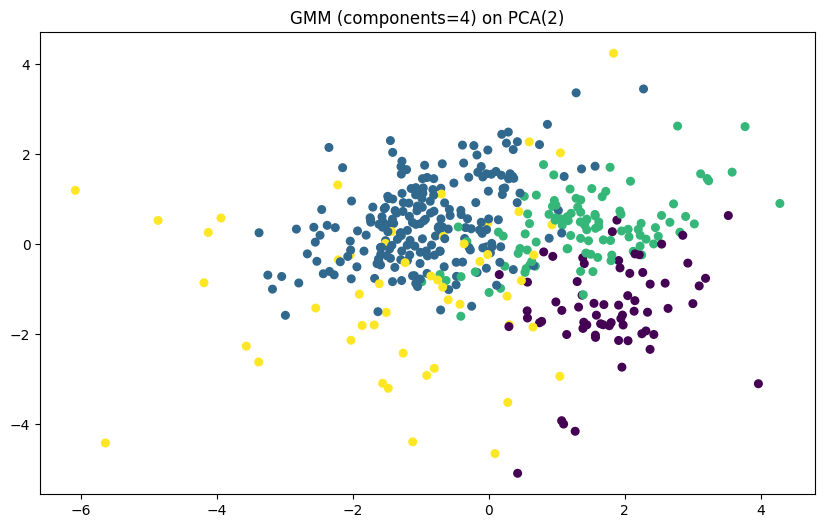

In [32]:
# Heading: 6. Gaussian Mixture Model (GMM) - choose components by BIC
bic = []
aic = []
for k in K_range:
  gmm = GaussianMixture(n_components=k, random_state=42)
  gmm.fit(X)
  bic.append(gmm.bic(X))
  aic.append(gmm.aic(X))


plt.figure()
plt.plot(list(K_range), bic, '-o', label='BIC')
plt.plot(list(K_range), aic, '-o', label='AIC')
plt.legend()
plt.title('GMM: BIC/AIC vs n_components')


k_opt_gmm = K_range[int(np.argmin(bic))]
print('GMM BIC-optimal components =', k_opt_gmm)


gmm_final = GaussianMixture(n_components=k_opt_gmm, random_state=42)
gmm_labels = gmm_final.fit_predict(X)


plt.figure()
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=gmm_labels, s=30)
plt.title(f'GMM (components={k_opt_gmm}) on PCA(2)')

Suggested eps (95th percentile) = 2.139622593121288
eps=2.5675 -> clusters=1, noise=0.91%


Text(0.5, 1.0, 'DBSCAN (eps=2.1396) on PCA(2)')

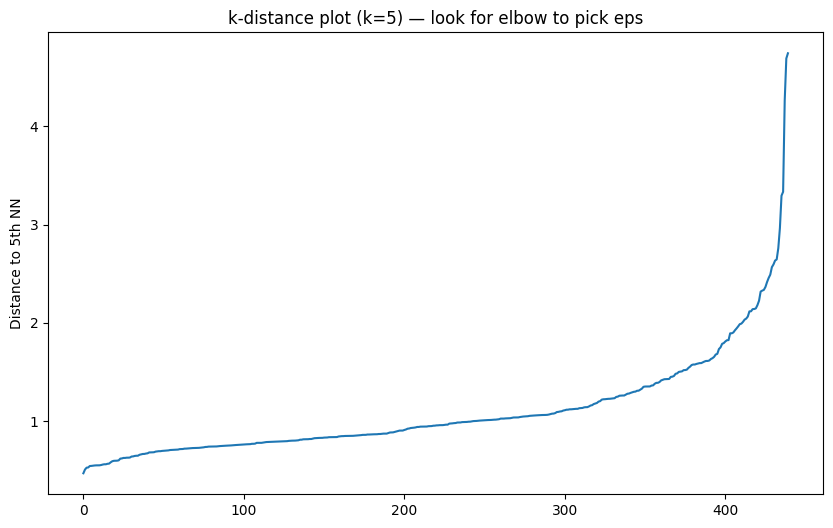

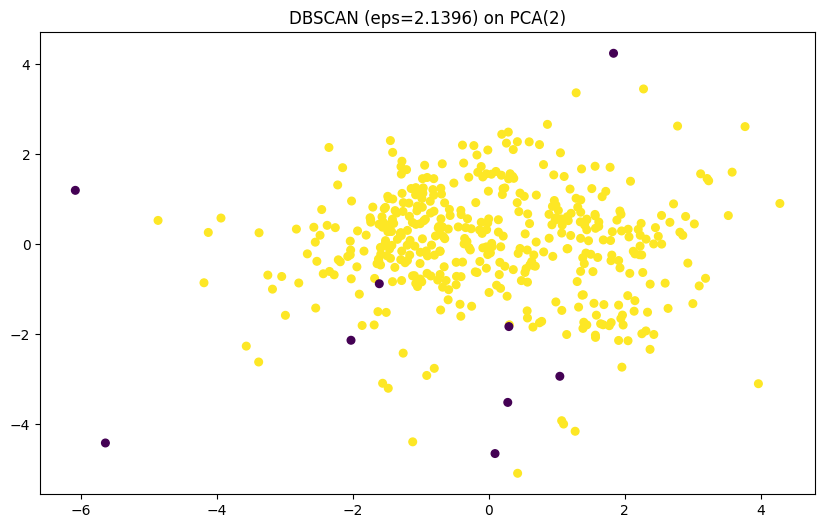

In [33]:
# Heading: 7. DBSCAN clustering
# Use kNN distance plot to choose eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
# distances to 4th neighbor (k-distance plot)
distances = np.sort(distances[:,4])


plt.figure()
plt.plot(distances)
plt.title('k-distance plot (k=5) — look for elbow to pick eps')
plt.ylabel('Distance to 5th NN')


# You should visually inspect this plot and choose eps. We'll provide an example guess.
# Example: eps_guess = np.percentile(distances, 95)
eps_guess = float(np.percentile(distances, 95))
print('Suggested eps (95th percentile) =', eps_guess)


# Try a few eps values
for eps in [eps_guess*0.6, eps_guess*0.8, eps_guess, eps_guess*1.2]:
  db = DBSCAN(eps=eps, min_samples=5).fit(X)
  labels = db.labels_
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  noise_pct = np.mean(labels==-1) * 100
print(f'eps={eps:.4f} -> clusters={n_clusters}, noise={noise_pct:.2f}%')


# Fit final DBSCAN with the chosen eps (here using eps_guess)
db_final = DBSCAN(eps=eps_guess, min_samples=5).fit(X)
db_labels = db_final.labels_


plt.figure()
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=db_labels, s=30)
plt.title(f'DBSCAN (eps={eps_guess:.4f}) on PCA(2)')

In [34]:
# Heading: 8. Post-analysis: cluster sizes and interpretation


def cluster_summary(labels, name='cluster'):
  labels = pd.Series(labels)
  counts = labels.value_counts().sort_index()
  print(f'--- {name} cluster counts ---')
  print(counts)
  print('\nPercentage:')
  print((counts / counts.sum() * 100).round(2))


cluster_summary(kmeans_labels, 'KMeans')
cluster_summary(agg_labels, 'Agglomerative')
cluster_summary(gmm_labels, 'GMM')
cluster_summary(db_labels, 'DBSCAN')


# For each cluster, compute mean values on original features (non-standardized)
for lab, lbls in [('KMeans', kmeans_labels), ('GMM', gmm_labels), ('DBSCAN', db_labels)]:
  print(f'\n--- {lab} cluster feature means ---')
  tmp = features.copy()
  tmp['cluster'] = lbls
  display(tmp.groupby('cluster').mean())

--- KMeans cluster counts ---
0    252
1    188
Name: count, dtype: int64

Percentage:
0    57.27
1    42.73
Name: count, dtype: float64
--- Agglomerative cluster counts ---
0    178
1    262
Name: count, dtype: int64

Percentage:
0    40.45
1    59.55
Name: count, dtype: float64
--- GMM cluster counts ---
0     67
1    218
2    103
3     52
Name: count, dtype: int64

Percentage:
0    15.23
1    49.55
2    23.41
3    11.82
Name: count, dtype: float64
--- DBSCAN cluster counts ---
-1      9
 0    431
Name: count, dtype: int64

Percentage:
-1     2.05
 0    97.95
Name: count, dtype: float64

--- KMeans cluster feature means ---


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,
0,13973.126984,2401.750000,2918.706349,3705.670635,491.944444,1038.043651
1,9355.867021,10346.361702,14697.063830,2222.452128,6084.505319,2177.425532



--- GMM cluster feature means ---


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,
0,4439.373134,9389.432836,15917.477612,691.671642,7482.895522,1166.313433
1,14946.100917,3103.064220,3206.000000,4428.087156,532.724771,1345.444954
2,11193.058252,9697.000000,14032.990291,1811.728155,6060.990291,1973.786408
3,10991.500000,4730.884615,5534.326923,2949.557692,501.673077,1849.865385



--- DBSCAN cluster feature means ---


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,
-1,10988.111111,9902.777778,9384.888889,7459.555556,651.555556,5577.444444
0,12021.433875,5710.515081,7921.341067,2980.310905,2928.058005,1440.245940


In [26]:
save_df = df.copy()
save_df['kmeans_cluster'] = kmeans_labels
save_df['gmm_cluster'] = gmm_labels
save_df['dbscan_cluster'] = db_labels
save_df.to_csv('wholesale_customers_with_clusters.csv', index=False)
print('Saved labels to wholesale_customers_with_clusters.csv')

Saved labels to wholesale_customers_with_clusters.csv
